In [1]:
import os    
import cv2  
import argparse
import time
import numpy as np
from scipy import ndimage
from skimage.transform import resize

from utils.depth_utils import *
from utils.register_utils import *

import torch
import plotly.graph_objects as go

data_map_txt={"01184":"An outdoor trash can with wheels", # Wheelie-Bin
              "06127":"A plant in a large vase", # vase
              "06830":"Children's tricycle with adult's handle" , # tricycle
              "07306":"An office trash can", # trash can
              "05452":"An a outside chair", # arm chair
              "06145":"A one leg square table", # table
              "05117":"A chair", # chair
              "06188":"A motorcycle", # vespa
              "07136":"A couch", # sofa
              "09639":"An executive chair"} # Swivel chair

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# params
parser = argparse.ArgumentParser()
parser.add_argument(
    "--obj_id",
    type=str,
    default="09639",
    choices=data_map_txt.keys(),
    help="Object ID to process",
)
parser.add_argument(
    "--verbose",
    action="store_true",
    help="Enable verbose output",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="./output",
    help="Directory to save output images",
)
parser.add_argument(
    "--gen_rgb",
    action="store_true",
    help="Generate RGB image using ControlNet",
)
parser.add_argument(
    "--depth_inpainting",
    action="store_true",
    help="Enable depth inpainting",
)
parser.add_argument(
    "--inference_steps",
    type=int,
    default=100,
    help="Number of inference steps for image generation",
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="Random seed for reproducibility",
)
args = parser.parse_args(['--obj_id', '05117', 
                          '--verbose', 
                          '--gen_rgb', 
                          '--depth_inpainting', 
                          '--inference_steps', '50'])
print(args)

Namespace(obj_id='05117', verbose=True, output_dir='./output', gen_rgb=True, depth_inpainting=True, inference_steps=50, seed=42)


In [3]:
# Set the random seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

object_id = args.obj_id
verbose = args.verbose
depth_inpainting = args.depth_inpainting
output_dir = args.output_dir
os.makedirs(output_dir, exist_ok=True)

In [4]:
pcl_path = f'./redwood_dataset/point_clouds/{object_id}.ply'
partial_pcl = o3d.io.read_point_cloud(pcl_path)
partial_pcl_translate = -partial_pcl.get_center()
partial_pcl = partial_pcl.translate(partial_pcl_translate)
partial_pcl_scale = 1.0 / np.max(np.linalg.norm(np.asarray(partial_pcl.points), axis=1))
partial_pcl_scale_center = np.asarray((0, 0, 0))
partial_pcl = partial_pcl.scale(partial_pcl_scale, center=partial_pcl_scale_center)
partial_pcl = np.asarray(partial_pcl.points)

In [67]:
from tqdm import tqdm
point_cloud = partial_pcl
n_cam=2000
width=512
height=512
fov_deg=60
radius = 2.0
low_res_ratio=1/8
look_at = np.array([0, 0, 0])
up=np.array([0,1,0])

best_camera = np.zeros(3)
best_visible_count = -1

camera_positions_sphere = generate_camera_positions(n_cam, radius=radius)
camera_positions_sphere_vis = np.zeros((n_cam))
camera_positions_sphere_v_count = np.zeros((n_cam))

for i in tqdm(range(n_cam)):
    camera = camera_positions_sphere[i]
    n_vis, _ = camera_depth_visibility(point_cloud, camera, look_at, up, width, height, fov_deg)
    v_count, vis_indices, _, _ = camera_hull_visibility(point_cloud, camera)
    camera_positions_sphere_vis[i] = n_vis
    camera_positions_sphere_v_count[i] = v_count
camera_positions_sphere_vis = camera_positions_sphere_vis / np.max(camera_positions_sphere_vis)
camera_positions_sphere_v_count = camera_positions_sphere_v_count / np.max(camera_positions_sphere_v_count)

100%|██████████| 2000/2000 [00:50<00:00, 39.43it/s]


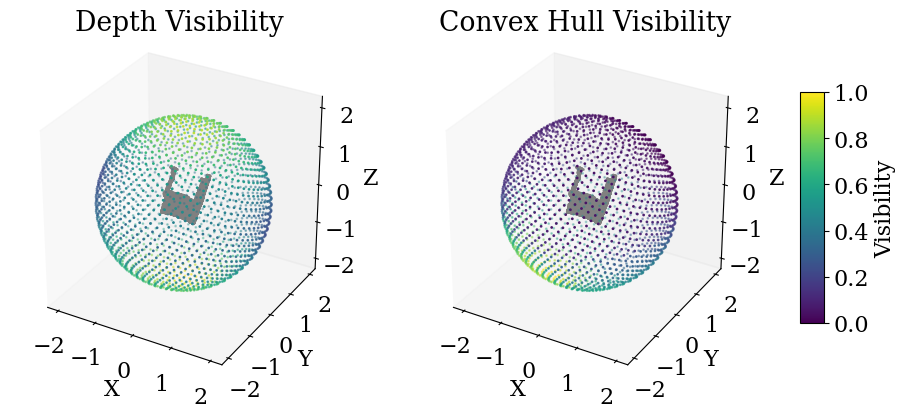

In [80]:
# Use matplotlib to visualize the camera positions, visiblility, and v_count, in two subplots with a shared colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

# Set the font style for the plots
plt.rcParams['font.family'] = 'serif'
# Set the font size for the plots
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
norm = Normalize(vmin=0, vmax=1)
cmap = cm.viridis
# Plot camera positions
pcl = ax1.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='gray', s=1)
sc = ax1.scatter(camera_positions_sphere[:, 0], camera_positions_sphere[:, 1], camera_positions_sphere[:, 2], 
                 c=camera_positions_sphere_vis, cmap=cmap, norm=norm, s=1)
ax1.set_title('Depth Visibility')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_aspect('equal')
ax1.set_box_aspect([1,1,1])
ax1.grid(False)
# ax1.view_init(elev=20, azim=30)
# Plot camera positions
pcl = ax2.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c='gray', s=1)
sc2 = ax2.scatter(camera_positions_sphere[:, 0], camera_positions_sphere[:, 1], camera_positions_sphere[:, 2], 
                  c=camera_positions_sphere_v_count, cmap=cmap, norm=norm, s=1)
ax2.set_title('Convex Hull Visibility')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_aspect('equal')
ax2.set_box_aspect([1,1,1])
ax2.grid(False)
# ax2.view_init(elev=20, azim=30)
# Add colorbar
cbar = fig.colorbar(sc, ax=[ax1, ax2], shrink=0.5, aspect=10)
cbar.set_label('Visibility')
plt.show()

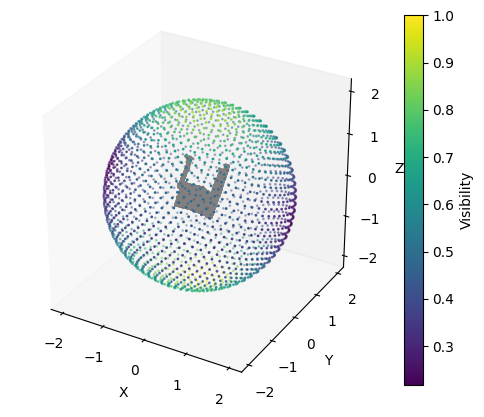

In [70]:
# Use matplotlib to visualize the camera positions and visiblility
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(camera_positions_sphere[:, 0], 
           camera_positions_sphere[:, 1], 
           camera_positions_sphere[:, 2], c=camera_positions_sphere_vis, cmap='viridis', marker='o', s=1)
ax.scatter(partial_pcl[:, 0],
           partial_pcl[:, 1], 
           partial_pcl[:, 2], c='gray', marker='o', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
# no grid no ticks no box
ax.set_box_aspect([1,1,1])
ax.grid(False)
# ax.set_title('Camera Positions and Visibility via Depth Estimation')
plt.colorbar(ax.collections[0], label='Visibility')
plt.savefig(f'camera_positions_{object_id}.png')

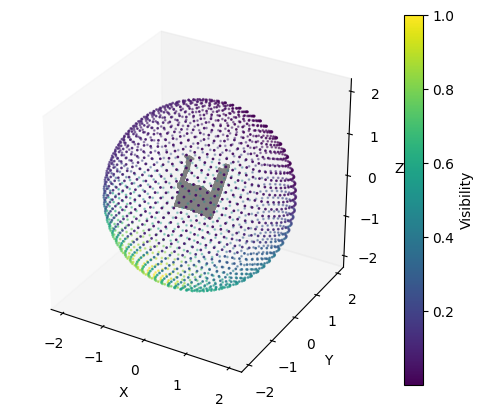

In [71]:
# Use matplotlib to visualize the camera positions and visiblility
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(camera_positions_sphere[:, 0], 
           camera_positions_sphere[:, 1], 
           camera_positions_sphere[:, 2], c=camera_positions_sphere_v_count, cmap='viridis', marker='o', s=1)
ax.scatter(partial_pcl[:, 0],
           partial_pcl[:, 1], 
           partial_pcl[:, 2], c='gray', marker='o', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')
# no grid no ticks no box
ax.set_box_aspect([1,1,1])
ax.grid(False)
# ax.set_title('Camera Positions and Visibility via Depth Estimation')
plt.colorbar(ax.collections[0], label='Visibility')
plt.savefig(f'camera_positions_v_count_{object_id}.png')

In [27]:
# _, _, best_depth_map, best_depth_map_low, _ = find_best_camera_iter_w_low(partial_pcl, 
#                                                                         n_cam_hull=500, 
#                                                                         n_cam_depth_iter=100, 
#                                                                         radius=2.0,
#                                                                         width=512,
#                                                                         height=512,
#                                                                         fov_deg=60,
#                                                                         low_res_ratio=1/8)

point_cloud = partial_pcl
n_cam_hull=500
n_cam_depth_iter=100
width=512
height=512
fov_deg=60
radius = 2.0
low_res_ratio=1/8
look_at = np.array([0, 0, 0])
up=np.array([0,1,0])

best_camera = np.zeros(3)
best_visible_count = -1

camera_positions_hull = generate_camera_positions(n_cam_hull, radius=radius)
best_camera, best_visible_count = find_best_camera_hull(point_cloud, camera_positions_hull)
_, best_depth = camera_depth_visibility(point_cloud, best_camera, look_at, up, width, height, fov_deg)

best_camera_prev = best_camera
delta_best = 1.0
n_iters = 0

best_camera_trajectory = [best_camera]
best_depth_map_trajectory = [best_depth]
camera_positions_all_trajectory = [camera_positions_hull]

camera_positions_all = camera_positions_hull

while delta_best > 1e-3 or n_iters < 5:
    r_curr = radius / (2**(0.25*(n_iters+1)))
    print("[INFO] Current radius:", r_curr)
    camera_positions_depth = generate_camera_positions_disk(n_cam_depth_iter, 
                                                            center=best_camera, 
                                                            radius=r_curr,
                                                            normal=best_camera / radius)
    camera_positions_depth = camera_positions_depth / np.linalg.norm(camera_positions_depth, axis=1)[:, None] * radius
    cam, count, best_depth_map = find_best_camera_depth(point_cloud, 
                                                        camera_positions_depth,
                                                        width=width,
                                                        height=height,
                                                        fov_deg=fov_deg)
    if count > best_visible_count:
        best_visible_count = count
        best_camera_prev = best_camera
        best_camera = cam
        print("[INFO] Best camera position:", best_camera)
        print("[INFO] Best visible count:", best_visible_count)
        delta_best = np.linalg.norm(best_camera_prev - best_camera)
    else:
        delta_best = 0.0
    
    
    n_iters += 1
    print("Iteration:", n_iters, "Best visible count:", best_visible_count)
    
    camera_positions_all = np.vstack((camera_positions_all, camera_positions_depth))
    best_camera_trajectory.append(best_camera)
    best_depth_map_trajectory.append(best_depth_map)
    camera_positions_all_trajectory.append(camera_positions_all)


Computing visibility with convex hull: 100%|██████████| 500/500 [00:04<00:00, 113.31it/s]


[INFO] Current radius: 1.6817928305074292


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 59.86it/s]


[INFO] Best camera position: [-0.05962432  0.01003741 -1.99908584]
[INFO] Best visible count: 42691
Iteration: 1 Best visible count: 42691
[INFO] Current radius: 1.414213562373095


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.70it/s]


[INFO] Best camera position: [ 0.03349565  0.04623064 -1.99918503]
[INFO] Best visible count: 42850
Iteration: 2 Best visible count: 42850
[INFO] Current radius: 1.189207115002721


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.04it/s]


Iteration: 3 Best visible count: 42850
[INFO] Current radius: 1.0


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.18it/s]


Iteration: 4 Best visible count: 42850
[INFO] Current radius: 0.8408964152537146


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.12it/s]


[INFO] Best camera position: [-0.01205135 -0.04602424 -1.99943405]
[INFO] Best visible count: 42872
Iteration: 5 Best visible count: 42872
[INFO] Current radius: 0.7071067811865475


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.41it/s]


[INFO] Best camera position: [ 0.03453864 -0.02790803 -1.999507  ]
[INFO] Best visible count: 42881
Iteration: 6 Best visible count: 42881
[INFO] Current radius: 0.5946035575013605


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 57.13it/s]

Iteration: 7 Best visible count: 42881


In [30]:
import imageio
# Make a gif of the best depth map trajectory
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# images = []
# for i in range(5):
#     best_depth_map = best_depth_map_trajectory[i]
#     plt.imshow(best_depth_map, cmap='gray')
#     plt.axis('off')
#     plt.axis('equal')
#     plt.title(f"Best Depth Map {i}")
#     plt.savefig(os.path.join(output_dir, f'best_depth_map_{i}.png'), bbox_inches='tight', pad_inches=0)
#     plt.close()
#     images.append(imageio.imread(os.path.join(output_dir, f'best_depth_map_{i}.png')))
    
# imageio.mimsave(os.path.join(output_dir, f'best_depth_map_trajectory.gif'), images, duration=500.0)

images = []
# Visualze the camera positions and the best camera in plotly for each iteration
for i in range(5):
    camera_positions_hull = camera_positions_all_trajectory[i]
    best_camera = best_camera_trajectory[i]
    point_cloud = partial_pcl
    object_id = args.obj_id
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-point_cloud[:, 0], -point_cloud[:, 1], -point_cloud[:, 2], s=2, c='blue', label=f'Object Point Cloud id={object_id}')
    ax.scatter(-best_camera[0], -best_camera[1], -best_camera[2], s=20, c='red', label='Best Camera Position')
    ax.scatter(-camera_positions_hull[:, 0], -camera_positions_hull[:, 1], -camera_positions_hull[:, 2], 
               s=5, c='green', label='Camera Positions', alpha=0.25)
    ax.set_title(f'Camera Positions and Best Camera for Object {object_id}')
    ax.view_init(elev=90, azim=-30)
    ax.set_axis_off()
    # equal aspect ratio
    ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1
    fig.savefig(os.path.join(output_dir, f'camera_positions_{i}.png'), bbox_inches='tight', pad_inches=0)
    plt.close()
    images.append(imageio.imread(os.path.join(output_dir, f'camera_positions_{i}.png')))
    
imageio.mimsave(os.path.join(output_dir, f'camera_positions_trajectory.gif'), images, duration=500.0)

#     fig = go.Figure()
#     fig.add_trace(go.Scatter3d(
#         x=-point_cloud[:, 0],
#         y=-point_cloud[:, 1],
#         z=-point_cloud[:, 2],
#         mode='markers',
#         marker=dict(size=2, color='blue'),
#         name=f'Object Point Cloud id={object_id}',
#     ))
#     fig.add_trace(go.Scatter3d(
#         x=[-best_camera[0]],
#         y=[-best_camera[1]],
#         z=[-best_camera[2]],
#         mode='markers',
#         marker=dict(size=5, color='red'),
#         name='Best Camera Position',
#     ))
#     fig.add_trace(go.Scatter3d(
#         x=-camera_positions_hull[:, 0],
#         y=-camera_positions_hull[:, 1],
#         z=-camera_positions_hull[:, 2],
#         mode='markers',
#         marker=dict(size=2, color='green'),
#         name='Camera Positions',
#     ))
#     fig.update_layout(
#         title=f'Camera Positions and Best Camera for Object {object_id} - Iteration {i}',
#         scene=dict(
#             xaxis_title='X',
#             yaxis_title='Y',
#             zaxis_title='Z',
#             aspectmode='data',
#             camera=dict(
#                 eye=dict(x=0, y=-1.5, z=1),
#                 up=dict(x=0, y=0, z=1)
#             )
#         ),
#         width=1200,
#         height=1200,
#         margin=dict(l=0, r=0, b=0, t=0),
#     )
#     # no grids and box
#     fig.update_layout(scene=dict(
#         xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#         yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#         zaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#     ))
#     fig.write_image(os.path.join(output_dir, f'camera_positions_{i}.png'))
#     images.append(imageio.imread(os.path.join(output_dir, f'camera_positions_{i}.png')))

# imageio.mimsave(os.path.join(output_dir, f'camera_positions_trajectory.gif'), images, duration=500.0)

/tmp/ipykernel_138269/552676692.py:40: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [ ]:
_, _, best_depth_map, best_depth_map_low, _ = find_best_camera_iter_w_low(partial_pcl, 
                                                                        n_cam_hull=500, 
                                                                        n_cam_depth_iter=100, 
                                                                        radius=2.0,
                                                                        width=512,
                                                                        height=512,
                                                                        fov_deg=60,
                                                                        low_res_ratio=1/8)

depth_map_c = cv2.medianBlur(best_depth_map.astype(np.float32), 5)

Computing visibility with convex hull: 100%|██████████| 500/500 [00:06<00:00, 82.85it/s] 


[INFO] Best camera position: [-0.4771437  -0.82993849 -1.756     ]
[INFO] Best visible count: 1775
[INFO] Current radius: 1.6817928305074292


Computing visibility with depth map: 100%|██████████| 100/100 [00:01<00:00, 51.40it/s]


[INFO] Best camera position: [-0.26585946  0.31065251 -1.95775733]
[INFO] Best visible count: 38367
Iteration: 1 Best visible count: 38367
[INFO] Current radius: 1.414213562373095


Computing visibility with depth map: 100%|██████████| 100/100 [00:02<00:00, 47.29it/s]


[INFO] Best camera position: [-0.34054291  0.1550675  -1.96468435]
[INFO] Best visible count: 38450
Iteration: 2 Best visible count: 38450
[INFO] Current radius: 1.189207115002721


Computing visibility with depth map: 100%|██████████| 100/100 [00:02<00:00, 47.59it/s]


[INFO] Best camera position: [-0.26308069  0.18633039 -1.97384638]
[INFO] Best visible count: 38586
Iteration: 3 Best visible count: 38586
[INFO] Current radius: 1.0


Computing visibility with depth map: 100%|██████████| 100/100 [00:02<00:00, 47.57it/s]


Iteration: 4 Best visible count: 38586
[INFO] Current radius: 0.8408964152537146


Computing visibility with depth map: 100%|██████████| 100/100 [00:02<00:00, 47.50it/s]

Iteration: 5 Best visible count: 38586
[INFO] Best camera position: [-0.26308069  0.18633039 -1.97384638]
[INFO] Best visible count: 38586


In [7]:
if depth_inpainting:
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map_binary = cv2.threshold(depth_map_c, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary_low = cv2.threshold(best_depth_map_low, 0, 1, cv2.THRESH_BINARY)[1]
    depth_map_binary_low = cv2.GaussianBlur(depth_map_binary_low, (5,5), sigmaX=1.0, sigmaY=1.0)
    depth_map_binary_low_up = cv2.resize(depth_map_binary_low, (depth_map_c.shape[1], depth_map_c.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    depth_map_binary_low_up = cv2.threshold(depth_map_binary_low_up, 0.5, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_xor = cv2.bitwise_xor(depth_map_binary, depth_map_binary_low_up)
    depth_map_xor[depth_map_binary != 0] = 0
    from diffusers import StableDiffusionInpaintPipeline
    from PIL import Image
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )

    pipe.to("cuda")
    prompt = data_map_txt[object_id]
    negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig"
    #image and mask_image should be PIL images.
    # convert the depth map to a PIL image
    depth_map_image = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_map_image = cv2.cvtColor(depth_map_image, cv2.COLOR_GRAY2RGB)
    depth_map_image = cv2.resize(depth_map_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    # convert the binary mask to a PIL image
    mask_image = cv2.normalize(depth_map_xor, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)
    mask_image = cv2.resize(mask_image, (512, 512), interpolation=cv2.INTER_NEAREST)
    #The mask structure is white for inpainting and black for keeping as is
    depth_map = pipe(prompt=prompt, 
                        negative_prompt=negative_prompt, 
                        image=Image.fromarray(depth_map_image), 
                        mask_image=Image.fromarray(mask_image),
                num_inference_steps=100,
                guidance_scale=2.0
                ).images[0]
    depth_map = np.array(depth_map)
    make_image_grid([Image.fromarray(depth_map_image), 
                     Image.fromarray(mask_image), 
                     Image.fromarray(depth_map)], rows=1, cols=3).save(os.path.join(output_dir, f"{object_id}_depth_inpaint.png"))
else:
    # depth_map_c = cv2.medianBlur(depth_map_c.astype(np.float32), 5)
    depth_map = cv2.normalize(depth_map_c, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # increase a little bit contrast
    depth_map = cv2.convertScaleAbs(depth_map, alpha=0.9, beta=0)
    depth_map = cv2.cvtColor(depth_map, cv2.COLOR_GRAY2RGB)
    depth_map = cv2.resize(depth_map, (512, 512), interpolation=cv2.INTER_NEAREST)
    make_image_grid([Image.fromarray(depth_map)], rows=1, cols=1).save(os.path.join(output_dir, f"{object_id}_depth.png"))

# depth_map = cv2.flip(depth_map, 1)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

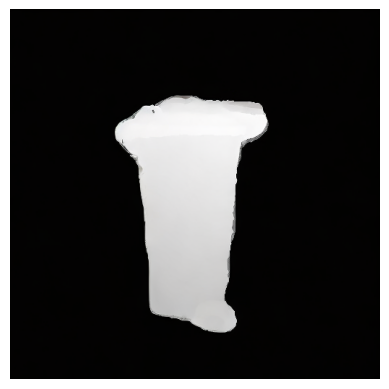

In [8]:
plt.imshow(depth_map)
plt.axis('off')
plt.show()

In [9]:
if args.gen_rgb:
    print("[INFO] Depth map generated, now generating image using ControlNet...")
    # auxiliary_prompt = ", clean background, no people, no animals"
    auxiliary_prompt = ""
    image = d2i_pipe(data_map_txt[object_id] + auxiliary_prompt,
                    Image.fromarray(depth_map), 
                    num_inference_steps=args.inference_steps,
                    # num_inference_steps=75,
                    guidance_scale = 6.0,
                    controlnet_conditioning_scale=1.1,
                    negative_prompt="bad anatomy, deformed, ugly, disfigured, \
                    intricate details, blurry, out of focus, bad art, bad anatomy",
                    # negative_prompt = "bad anatomy, deformed, ugly, disfigured, intricate details, blurry, out of focus, bad art, bad anatomy, disfig, intricate background",
                    # generator=torch.manual_seed(0),
                    # generator=torch.manual_seed(42),
                    ).images[0]
    image = remove(image)
else:
    depth_map_gray = cv2.cvtColor(depth_map, cv2.COLOR_RGB2GRAY)
    depth_map_gray = cv2.normalize(depth_map_gray, None, 0, 1, cv2.NORM_MINMAX)
    depth_map_binary = cv2.threshold(depth_map_gray, 0, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    depth_map_binary = cv2.medianBlur(depth_map_binary.astype(np.float32), 5)
    depth_map_rgba = cv2.cvtColor(depth_map, cv2.COLOR_RGB2RGBA)
    depth_map_rgba[depth_map_binary == 0] = (0, 0, 0, 0)
    depth_map_rgba = Image.fromarray(depth_map_rgba.astype(np.uint8))
    image = depth_map_rgba.copy()

[INFO] Depth map generated, now generating image using ControlNet...


  0%|          | 0/50 [00:00<?, ?it/s]

[INFO] Image prompt for Hunyuan3D:


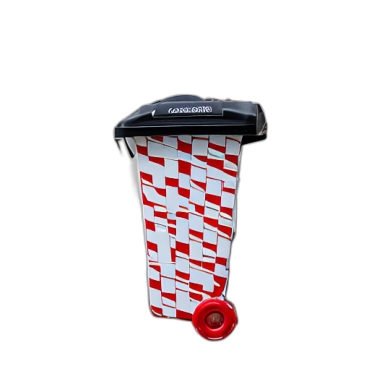

In [10]:
print("[INFO] Image prompt for Hunyuan3D:")
plt.imshow(image)
plt.axis('off')
plt.show()
image.save(os.path.join(output_dir, f"{object_id}_img_prompt.png"))

In [11]:
print("[INFO] Background removed, now generating mesh using Hunyuan3D...")
mesh = hunyuan3D_mesh_pipe(image=image,
                      num_inference_steps=args.inference_steps,
                      guidance_scale = 4.5,
                      )[0]
# print("[INFO] Mesh generated, now generating texture using Hunyuan3D...")
# mesh = hunyuan3D_paint_pipe(mesh=mesh,
#                             image=image_nobg,
#                             )[0]
# Save the mesh to a file
print("[INFO] Saving mesh...")
mesh.export(os.path.join(output_dir, f"{object_id}_mesh.ply"))
print(f"Mesh saved to {os.path.join(output_dir, f'{object_id}_mesh.ply')}")


[INFO] Background removed, now generating mesh using Hunyuan3D...


Diffusion Sampling::   0%|          | 0/50 [00:00<?, ?it/s]

Volume Decoding: 100%|██████████| 7134/7134 [00:15<00:00, 448.63it/s]


[INFO] Saving mesh...
Mesh saved to ./output/01184_mesh.ply


In [12]:
from open3d.web_visualizer import draw

# Visualize the mesh
print("[INFO] Visualizing mesh...")
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"{object_id}_mesh.ply"))
mesh.vertices = o3d.utility.Vector3dVector(np.asarray(mesh.vertices) * np.array([-1, 1, 1]))

draw([mesh])


[Open3D INFO] Resetting default logger to print to terminal.
[INFO] Visualizing mesh...
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
FEngine (64 bits) created at 0x7f20d4009af0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

In [13]:
# Register the mesh to the original point cloud
print("[INFO] Registering mesh to original point cloud...")

object_id = args.obj_id
# object_id = "01184"\

# np.random.seed(42)

# Load the ground truth mesh
complete_pcd = o3d.io.read_triangle_mesh(f"./redwood_dataset/GT/{object_id}.ply")
complete_pcd = complete_pcd.sample_points_uniformly(number_of_points=16384)
complete_pcd.points = o3d.utility.Vector3dVector(-np.asarray(complete_pcd.points))
translate = -complete_pcd.get_center()
complete_pcd = complete_pcd.translate(translate)
scale = 0.5 / np.max(np.linalg.norm(np.asarray(complete_pcd.points), axis=1))
complete_pcd = complete_pcd.scale(scale, center=complete_pcd.get_center())

# Load the partial point cloud
partial_pcd = o3d.io.read_point_cloud(f"./redwood_dataset/point_clouds/{object_id}.ply")
partial_pcd.points = o3d.utility.Vector3dVector(-np.asarray(partial_pcd.points))
partial_pcd = partial_pcd.translate(translate)
partial_pcd = partial_pcd.scale(scale, center=complete_pcd.get_center())
partial_pcd = partial_pcd.farthest_point_down_sample(num_samples=16384)

# Load the generated mesh
mesh = o3d.io.read_triangle_mesh(os.path.join(output_dir, f"{object_id}_mesh.ply"))
# Normalize the mesh
mesh = mesh.translate(-mesh.get_center())
mesh = mesh.scale(0.5 / np.max(np.linalg.norm(np.asarray(mesh.vertices), axis=1)), center=mesh.get_center())
mesh_pcd = mesh.sample_points_uniformly(number_of_points=16384)
mesh_pcd.points = o3d.utility.Vector3dVector(np.asarray(mesh_pcd.points) * np.array([-1, 1, 1]))

# # Register the mesh to the original point cloud
# scales = np.arange(0.8, 1.25, 0.025)
# # scales = np.meshgrid(scales, scales, scales)
# # scales = np.array(scales).reshape(3, -1).T
# # print(f"Number of scales: {scales[..., None].shape}")
# transformation = multiscale_registration(mesh_pcd, partial_pcd, scales, voxel_size=0.0025)

# mesh_pcd.transform(transformation)

from utils.gd_register_utils import gd_registration
mesh_pcd = gd_registration(mesh_pcd, partial_pcd, fps_sample=2048, device='cuda')

# mesh_pcd.transform(transformation)

# Compute the chamfer distance
cd_o3d = (np.mean(complete_pcd.compute_point_cloud_distance(mesh_pcd)) + \
    np.mean(mesh_pcd.compute_point_cloud_distance(complete_pcd))) / 2
print(f"Chamfer Distance: {cd_o3d}")

# from utils.chamfer_python import distChamfer
# cd_left, cd_right, index_left, index_right = distChamfer(torch.tensor(np.asarray(complete_pcd.points)).unsqueeze(0), 
#                  torch.tensor(np.asarray(mesh_pcd.points)).unsqueeze(0))
# print(cd_left.shape, cd_right.shape)
# cd = (cd_left.sqrt().mean(dim=1) + cd_right.sqrt().mean(dim=1))
# print(f"Chamfer Distance (PyTorch): {cd.item()}")

[INFO] Registering mesh to original point cloud...
Target point cloud shape: torch.Size([2048, 3])
Source point cloud shape: torch.Size([2048, 3])
Iteration    0: Loss = 0.002591
Iteration  100: Loss = 0.000183
Iteration  200: Loss = 0.000183
Iteration  300: Loss = 0.000184
Iteration  400: Loss = 0.000184
Iteration  500: Loss = 0.000207
Iteration  600: Loss = 0.000203
Iteration  700: Loss = 0.000194
Iteration  800: Loss = 0.000184
Iteration  900: Loss = 0.000191
Optimization complete.
Learned rotation angles (radians): [0.43109623 0.2518543  0.05007854]
Learned translation: [ 0.00679252  0.05512138 -0.00783697]
Learned scale: [1.0439692]
Chamfer Distance: 0.02514435025126331


In [14]:
# Write the registered mesh to a file
o3d.io.write_point_cloud(os.path.join(output_dir, f"{object_id}_pcd_complete_registered.ply"), mesh_pcd)

True

In [15]:
mesh_pcd.paint_uniform_color([0, 0, 1])
partial_pcd.paint_uniform_color([1, 0, 0])
complete_pcd.paint_uniform_color([0, 1, 0])
draw([mesh_pcd, partial_pcd, complete_pcd])

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

In [16]:

draw([mesh_pcd, partial_pcd])

[Open3D INFO] Window window_2 created.


WebVisualizer(window_uid='window_2')

In [17]:
# Show run time
end_time = time.time()
print(f"[INFO] Total run time: {end_time - start_time:.2f} seconds")
print(f"[INFO] Final Chamfer Distance: {cd_o3d:.4f}")
print(f"[INFO] Output saved to {output_dir}")

[INFO] Total run time: 56.22 seconds
[INFO] Final Chamfer Distance: 0.0251
[INFO] Output saved to ./output
